In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
from scipy import stats
from transformer_thermal_model.cooler import CoolerType
from transformer_thermal_model.model import Model
# from transformer_thermal_model.schemas import (
#     InputProfile,
#     ThreeWindingInputProfile,
#     UserThreeWindingTransformerSpecifications,
#     UserTransformerSpecifications,
#     WindingSpecifications,
# )
from transformer_thermal_model.schemas.thermal_model import CoolingSwitchConfig, CoolingSwitchSettings, ONANParameters
from transformer_thermal_model.transformer import PowerTransformer, ThreeWindingTransformer

ImportError: cannot import name 'CoolingSwitchConfig' from 'transformer_thermal_model.schemas.thermal_model' (/home/lunajansma/github/use-TTM/.venv/lib/python3.13/site-packages/transformer_thermal_model/schemas/thermal_model/__init__.py)

In [182]:
# Lees specifiek tabblad in uit de Excel file
sheet_name = "<VUL_HIER_DE_NAAM_VAN_HET_TABBLAD_IN>"  # Pas dit aan naar de naam van het gewenste tabblad
df = pd.read_excel(r"/home/lunajansma/github/transformer-thermal-model/docs/examples/measurement_data/Westhaven belastinggraad analyses.xlsx", 
                   sheet_name='MetingenZomer', decimal=',', header=0)
df['datetime'] = pd.to_datetime(df['Datum'] + ' ' + df['Tijd'], format='%Y-%m-%d %H:%M')
df = df.drop(columns={'Datum', 'Tijd'})
df = df.drop(0)
# filter op data waarop de transformator op ONAN/ONAF lijkt te staan
start_time = pd.to_datetime('2024-07-15')
end_time = pd.to_datetime('2024-09-07') 
mask = (df['datetime'] >= start_time) & (df['datetime'] <= end_time)
df = df.loc[mask]
topolie_column = 'Top-olie temperatuur'
omgeving_column = 'Omgevingstemperatuur'
belasting_column = 'Belasting'

In [183]:
# Create an input object with the profiles
my_profile_input = InputProfile.create(
    datetime_index=df['datetime'], load_profile=df['Belasting'], ambient_temperature_profile=df[omgeving_column]
)


In [184]:
my_transformer_specifications = UserTransformerSpecifications(
    load_loss=157200,  # Transformer load loss [W]
    nom_load_sec_side=1574.6,  # Transformer nominal current secondary side [A]
    no_load_loss=12590,  # Transformer no-load loss [W]
    amb_temp_surcharge=0,  # Ambient temperature surcharge [K]
    time_const_oil=150,  # Time constant oil [min]
    time_const_windings=7,  # Time constant windings [min]
    top_oil_temp_rise=51.3,  # Top-oil temperature rise [K]
    winding_oil_gradient=22.6,  # Winding oil gradient (worst case) [K]
    end_temp_reduction=0,  # Lowering of the end temperature with respect to the current specification [K]
    hot_spot_fac=1.2,  # Hot-spot factor [-]
    oil_const_k11=0.5,  # Oil constant k11 [-]
    winding_const_k21=2.0,  # Winding constant k21 [-]
    winding_const_k22=2.0,  # Winding constant k22 [-]
    oil_exp_x=0.8,  # Oil exponent x [-]
    winding_exp_y=1.3,  # Winding exponent x [-]
)

onan_specs = ONANParameters(
    top_oil_temp_rise=52.3,
    time_const_oil=210,
    time_const_windings=10,
    load_loss=69867,
    nom_load_sec_side=1050,  # Lower nominal current for ONAN mode
    winding_oil_gradient=15.6,
    hot_spot_fac=1.3,
)

onaf_switch = CoolingSwitchSettings(
    temperature_threshold=CoolingSwitchConfig(activation_temp=70, deactivation_temp=55),
    onan_parameters=onan_specs, fan_on=None
)

In [185]:
# met switch
my_transformer = PowerTransformer(
    user_specs=my_transformer_specifications, cooling_type=CoolerType.ONAF, cooling_switch_settings=onaf_switch
)
my_model = Model(temperature_profile=my_profile_input, transformer=my_transformer)
results = my_model.run()

# zonder switch
my_transformer_noswitch = PowerTransformer(
    user_specs=my_transformer_specifications, cooling_type=CoolerType.ONAF
)
my_model_noswitch = Model(temperature_profile=my_profile_input, transformer=my_transformer_noswitch)
results_noswitch = my_model_noswitch.run()

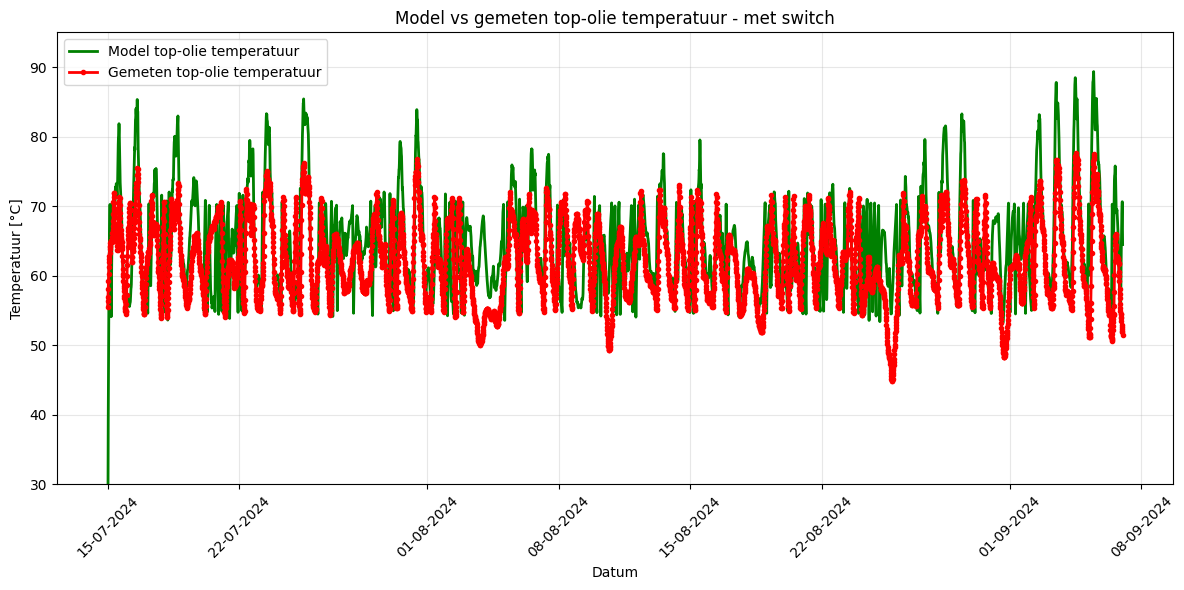

In [186]:
# volledige tijdseries met gemodelleerde switch
fig,ax = plt.subplots(figsize=(12, 6))

ax.plot(results.top_oil_temp_profile, label='Model top-olie temperatuur', color="green", linewidth=2)
ax.plot(df['datetime'], df[topolie_column], label='Gemeten top-olie temperatuur', color='red', linewidth=2, marker='o', markersize=3)

ax.set_ylabel("Temperatuur [°C]")
ax.set_xlabel("Datum")
ax.legend(loc="best")
ax.grid(True, alpha=0.3)
ax.set_title('Model vs gemeten top-olie temperatuur - met switch')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax.set_ylim(30,95)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


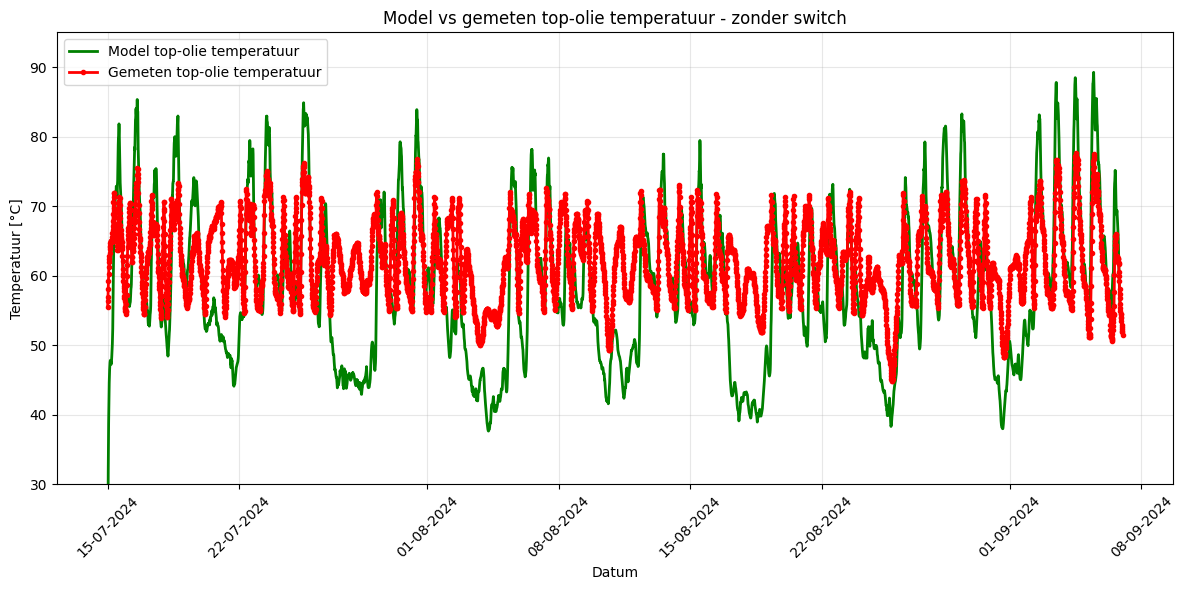

In [187]:
# volledige tijdseries zonder gemodelleerde switch
fig,ax = plt.subplots(figsize=(12, 6))

ax.plot(results_noswitch.top_oil_temp_profile, label='Model top-olie temperatuur', color="green", linewidth=2)
ax.plot(df['datetime'], df[topolie_column], label='Gemeten top-olie temperatuur', color='red', linewidth=2, marker='o', markersize=3)

ax.set_ylabel("Temperatuur [°C]")
ax.set_xlabel("Datum")
ax.legend(loc="best")
ax.grid(True, alpha=0.3)
ax.set_title('Model vs gemeten top-olie temperatuur - zonder switch')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax.set_ylim(30,95)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

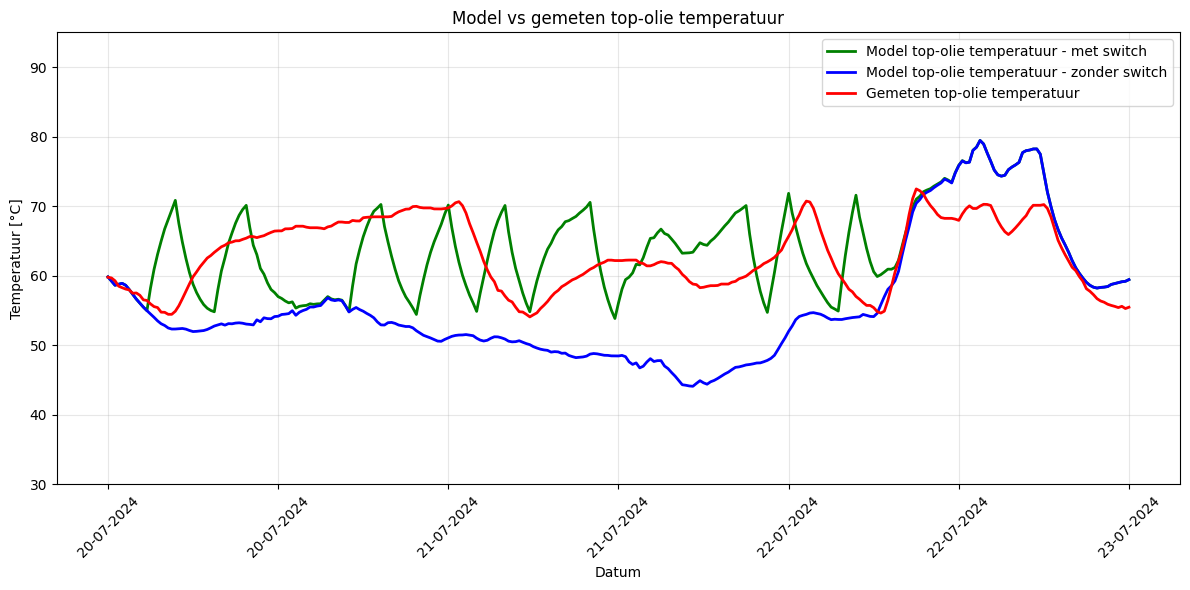

In [189]:
# tijdseries voor een aantal dagen met gemodelleerde switch
start_time = pd.to_datetime('2024-07-20') 
end_time = start_time + pd.Timedelta(days=3)
mask = (df['datetime'] >= start_time) & (df['datetime'] <= end_time)
fig,ax = plt.subplots(figsize=(12, 6))

ax.plot(results.top_oil_temp_profile.loc[start_time:end_time], label='Model top-olie temperatuur - met switch', color="green", linewidth=2)
ax.plot(results_noswitch.top_oil_temp_profile.loc[start_time:end_time], label='Model top-olie temperatuur - zonder switch', color="blue", linewidth=2)
ax.plot(df.loc[mask,'datetime'], df.loc[mask,topolie_column], label='Gemeten top-olie temperatuur', color='red',
         linewidth=2)

ax.set_ylabel("Temperatuur [°C]")
ax.set_xlabel("Datum")
ax.legend(loc="best")
ax.grid(True, alpha=0.3)
ax.set_title('Model vs gemeten top-olie temperatuur')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax.set_ylim(30,95)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

/tmp/ipykernel_1484/2898861117.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


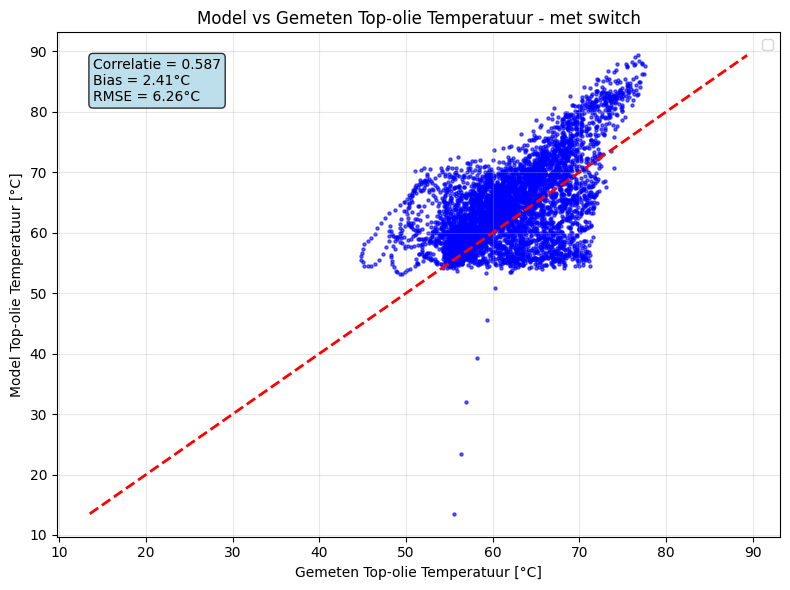

In [190]:
# scatterplot model vs meetwaarden met gemodelleerde switch
model_temps = results.top_oil_temp_profile
measured_temps = df[topolie_column]
measured_temps.index = df['datetime']
# Bereken statistieken
correlation = model_temps.corr(measured_temps)  # Correlatie
bias = np.nanmean(model_temps - measured_temps)  # Bias
rmse = np.sqrt(np.nanmean((model_temps - measured_temps)**2))  # RMSE

# Scatter plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(measured_temps, model_temps, alpha=0.6, s=5, color='blue')

# 1:1 lijn
min_temp = np.nanmin([np.nanmin(measured_temps), np.nanmin(model_temps)])
max_temp = np.nanmax([np.nanmax(measured_temps), np.nanmax(model_temps)])
ax.plot([min_temp, max_temp], [min_temp, max_temp], 'r--', linewidth=2)

ax.set_xlabel('Gemeten Top-olie Temperatuur [°C]')
ax.set_ylabel('Model Top-olie Temperatuur [°C]')
ax.set_title('Model vs Gemeten Top-olie Temperatuur - met switch')
ax.grid(True, alpha=0.3)
ax.legend()

# Statistieken
stats_text = f'''Correlatie = {correlation:.3f}
Bias = {bias:.2f}°C
RMSE = {rmse:.2f}°C'''

ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, 
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

plt.tight_layout()
plt.show()


/tmp/ipykernel_1484/2592078367.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


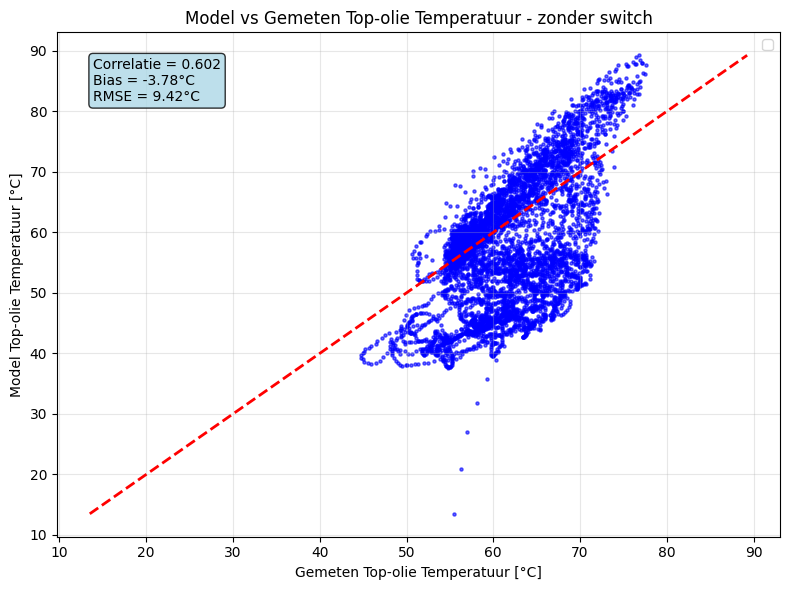

In [191]:
# scatterplot model vs meetwaarden zonder gemodelleerde switch
model_temps = results_noswitch.top_oil_temp_profile
measured_temps = df[topolie_column]
measured_temps.index = df['datetime']
# Bereken statistieken
correlation = model_temps.corr(measured_temps)  # Correlatie
bias = np.nanmean(model_temps - measured_temps)  # Bias
rmse = np.sqrt(np.nanmean((model_temps - measured_temps)**2))  # RMSE

# Scatter plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(measured_temps, model_temps, alpha=0.6, s=5, color='blue')

# 1:1 lijn
min_temp = np.nanmin([np.nanmin(measured_temps), np.nanmin(model_temps)])
max_temp = np.nanmax([np.nanmax(measured_temps), np.nanmax(model_temps)])
ax.plot([min_temp, max_temp], [min_temp, max_temp], 'r--', linewidth=2)

ax.set_xlabel('Gemeten Top-olie Temperatuur [°C]')
ax.set_ylabel('Model Top-olie Temperatuur [°C]')
ax.set_title('Model vs Gemeten Top-olie Temperatuur - zonder switch')
ax.grid(True, alpha=0.3)
ax.legend()

# Statistieken
stats_text = f'''Correlatie = {correlation:.3f}
Bias = {bias:.2f}°C
RMSE = {rmse:.2f}°C'''

ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, 
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

plt.tight_layout()
plt.show()
